# Molecular pipelines

In scikit-fingerprints, you can use scikit-learn `Pipeline` objects to create complex workflows for molecular processing. Thanks to full compatibility with scikit-learn API, we can easily build pipelines for molecular preprocessing, computing fingerprints, and further machine learning. The full pipeline still uses familiar `.fit()` and `.predict()` methods.

### Molecular property prediction pipeline

Here, we will perform molecular property prediction, i.e. graph classification in this case. We revisit the task from tutorial 1, where we used [beta-secretase 1 (BACE) dataset](https://doi.org/10.1021/acs.jcim.6b00290) from MoleculeNet benchmark.

We can easily chain all relevant operations in a single pipeline.

Also, note that for convenience `scaffold_train_test_split` and all fingerprints, e.g. `ECFPFingerprint` ([docs](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.ECFPFingerprint.html#skfp.fingerprints.ECFPFingerprint)) used below, can also take SMILES input. Those strings will be converted to molecules inside as necessary, since this is a very cheap operation. Whole pipeline then also takes lists of SMILES as inputs, instead of NumPy arrays, e.g. `smiles_train` instead of `X_train`.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline

from skfp.datasets.moleculenet import load_bace
from skfp.fingerprints import ECFPFingerprint
from skfp.model_selection import scaffold_train_test_split

smiles_list, y = load_bace()
smiles_train, smiles_test, y_train, y_test = scaffold_train_test_split(
    smiles_list, y, test_size=0.2
)

pipeline = make_pipeline(
    ECFPFingerprint(),
    RandomForestClassifier(random_state=0),
)
pipeline.fit(smiles_train, y_train)

y_pred = pipeline.predict_proba(smiles_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)

print(f"AUROC: {auroc:.2%}")

AUROC: 78.25%


### More complex molecular property prediction pipeline

We will reuse the pipeline from above, but also add a second [MACCS fingerprint](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.MACCSFingerprint.html#skfp.fingerprints.MACCSFingerprint) and concatenate it as additional features. Scikit-learn has a built-in `FeatureUnion` class for this, with `make_union` function for easy usage. As it often benefits from parallelism, we will add `n_jobs=-1` to it.

Since we may have all-zero features, we will also filter them out as another step, using `VarianceThreshold` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html)).

In [2]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_union

from skfp.fingerprints import MACCSFingerprint

pipeline = make_pipeline(
    make_union(ECFPFingerprint(), MACCSFingerprint(n_jobs=-1)),
    VarianceThreshold(),
    RandomForestClassifier(random_state=0),
)
pipeline.fit(smiles_train, y_train)

y_pred = pipeline.predict_proba(smiles_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)

print(f"AUROC: {auroc:.2%}")

AUROC: 78.49%


### Pipeline for dimensionality reduction and visualization

Here, we will build a visualization pipeline that uses dimensionality reduction for 2D visualization.

[UMAP](https://umap-learn.readthedocs.io/en/latest/) is a particularly powerful, yet easy to use nonlinear dimensionality reduction. It requires using some distance metric, which is used for pairwise distance calculation. While scikit-fingerprints implements [distance and similarity measures](https://scikit-fingerprints.readthedocs.io/latest/modules/distances.html) commonly used in chemoinformatics, like [Tanimoto distance](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.distances.tanimoto_binary_distance.html), UMAP also supports it directly under the name `"jaccard"`. Lastly, we'll plot the training and testing data with Matplotlib.

Since neither UMAP, nor Matplotlib are required by `scikit-fingerprints`, we will install them separately.

In [3]:
!pip install --quiet matplotlib umap-learn

/home/jakub/.cache/pypoetry/virtualenvs/scikit-fingerprints-VjWItXgH-py3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jakub/.cache/pypoetry/virtualenvs/scikit-fingerprints-VjWItXgH-py3.9/lib/python3.9/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/home/jakub/.cache/pypoetry/virtualenvs/scikit-fingerprints-VjWItXgH-py3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jakub/.cache/pypoetry/virtualenvs/scikit-fingerprints-VjWItXgH-py3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed

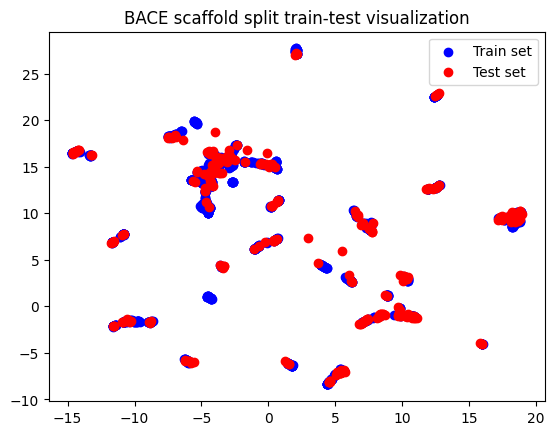

In [4]:
import matplotlib.pyplot as plt
from umap import UMAP

pipeline = make_pipeline(
    ECFPFingerprint(),
    UMAP(n_components=2, metric="jaccard", n_jobs=-1),
)
pipeline.fit(smiles_train)

X_train = pipeline.transform(smiles_train)
X_test = pipeline.transform(smiles_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c="b", label="Train set")
plt.scatter(X_test[:, 0], X_test[:, 1], c="r", label="Test set")
plt.title("BACE scaffold split train-test visualization")
plt.legend()
plt.show()

### Pipelines with conformational fingerprints

Some fingerprints, like [RDF fingerprint](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.fingerprints.RDFFingerprint.html), are based on the 3D (spatial) structure of a molecule conformer. They can be easily generated in scikit-fingerprints with [ConformerGenerator](https://scikit-fingerprints.readthedocs.io/latest/modules/generated/skfp.preprocessing.ConformerGenerator.html), which uses ETKDGv3 algorithm underneath. This information is saved as a molecule attribute, and such molecules can be vectorized with both conformational fingerprints and regular ones. Note that conformer generation is hard, and can sometimes fail. It is also quite computationally expensive, and using parallelization is very useful.

We will use both conformational RDF fingerprint and topological ("flat") ECFP fingerprint here, concatenated to create a more rich feature space for classification. Since they create features with really different value ranges, we'll add min-max scaling. This is particularly important for linear classifiers and anything not based on decision trees. To make things more interesting, we will use logistic regression, the most popular linear model.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

from skfp.fingerprints import RDFFingerprint
from skfp.preprocessing import ConformerGenerator, MolFromSmilesTransformer

pipeline = make_pipeline(
    MolFromSmilesTransformer(),
    ConformerGenerator(n_jobs=-1),
    make_union(RDFFingerprint(), ECFPFingerprint()),
    MinMaxScaler(),
    LogisticRegression(max_iter=1000, random_state=0),
)
pipeline.fit(smiles_train, y_train)

y_pred = pipeline.predict_proba(smiles_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred)

print(f"AUROC: {auroc:.2%}")

AUROC: 78.22%
